### Package imports

In [4]:
import pandas as pd
import numpy as np
import os
import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Data import

In [2]:
os.listdir('data')

['census_income_test.csv',
 'countries.geojson',
 'features.txt',
 'census_income_learn.csv',
 'census_income_metadata.txt']

In [3]:
# collecting the features from an extract of the metadata file
with open('data/features.txt', 'r') as f:
    l = f.readlines()
    features = {}
    for f in l:
        s = f[2:-1].split('\t')
        features[s[-1]] = s[0].lower().replace(' ', '_').replace('-','_')

# removing the unused features and fixing small naming issues
unused_features = ['AGI', 'FEDTAX', 'PEARNVAL', 'PTOTVAL', 'TAXINC']
for f in unused_features:
    del features[f]
    
features['ARACE'] = 'race'
features['DIVVAL'] = 'divdends_from_stocks'
features['VETQVA'] = 'fill_inc_questionnaire_for_veterans_admin'

# adding the missing variables
features['YEAR'] = 'year'
features['YTARGET'] = 'income class'

pprint.pprint(features)

{'AAGE': 'age',
 'ACLSWKR': 'class_of_worker',
 'ADTIND': 'industry_code',
 'ADTOCC': 'occupation_code',
 'AHGA': 'education',
 'AHRSPAY': 'wage_per_hour',
 'AHSCOL': 'enrolled_in_edu_inst_last_wk',
 'AMARITL': 'marital_status',
 'AMJIND': 'major_industry_code',
 'AMJOCC': 'major_occupation_code',
 'ARACE': 'race',
 'AREORGN': 'hispanic_origin',
 'ASEX': 'sex',
 'AUNMEM': 'member_of_a_labor_union',
 'AUNTYPE': 'reason_for_unemployment',
 'AWKSTAT': 'full_or_part_time_employment_stat',
 'CAPGAIN': 'capital_gains',
 'CAPLOSS': 'capital_losses',
 'DIVVAL': 'divdends_from_stocks',
 'FILESTAT': 'tax_filer_status',
 'GRINREG': 'region_of_previous_residence',
 'GRINST': 'state_of_previous_residence',
 'HHDFMX': 'detailed_household_and_family_stat',
 'HHDREL': 'detailed_household_summary_in_household',
 'MARSUPWT': 'instance_weight',
 'MIGMTR1': 'migration_code_change_in_msa',
 'MIGMTR3': 'migration_code_change_in_reg',
 'MIGMTR4': 'migration_code_move_within_reg',
 'MIGSAME': 'live_in_this_ho

Note : this method relies on the fact that the features in the dataset follow the same order than the ones listed in the metadata file. Thus, using a Python $\texttt{dict}$ to list them and enrich them with a description will not cause any trouble at the stage below:

In [5]:
test = pd.read_csv('data/census_income_test.csv', names=list(features))
train = pd.read_csv('data/census_income_learn.csv', names=list(features))

### Data cleaning

We operate a small yet important change now which is to convert the income class "YTARGET" to a boolean - 0 being now the class "income < 50k" and 1 "income >= 50k". This is essential because our main task consists in classifying between two classes and they have to be unequivocally identifiable.

In [6]:
train.YTARGET = (train.YTARGET==' 50000+.')
test.YTARGET = (test.YTARGET==' 50000+.')

In [7]:
train.head()

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,...,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,YEAR,YTARGET
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,False
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,False
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,False
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,False
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,False


In [13]:
from collections import Counter

# Quick verification that the proportions didn't change
print(Counter(train.YTARGET == 1))
print(Counter(test.YTARGET == 1))

Counter({False: 187141, True: 12382})
Counter({False: 93576, True: 6186})


In [15]:
# Dropping column MARSUPWT as advised in the metadata file
train = train.drop(columns=['MARSUPWT'])
test = test.drop(columns=['MARSUPWT'])

KeyError: "['MARSUPWT'] not found in axis"

In [16]:
# Printing each unique values for columns containing strings
# Purpose : detecting which values should be considered as NA
for c in train.columns.tolist():
    if train[c].dtype=='object':
        print(c)
        print('----------------')
        for v in train[c].unique():
            print(v)
        print('\n')

ACLSWKR
----------------
 Not in universe
 Self-employed-not incorporated
 Private
 Local government
 Federal government
 Self-employed-incorporated
 State government
 Never worked
 Without pay


AHGA
----------------
 High school graduate
 Some college but no degree
 10th grade
 Children
 Bachelors degree(BA AB BS)
 Masters degree(MA MS MEng MEd MSW MBA)
 Less than 1st grade
 Associates degree-academic program
 7th and 8th grade
 12th grade no diploma
 Associates degree-occup /vocational
 Prof school degree (MD DDS DVM LLB JD)
 5th or 6th grade
 11th grade
 Doctorate degree(PhD EdD)
 9th grade
 1st 2nd 3rd or 4th grade


AHSCOL
----------------
 Not in universe
 High school
 College or university


AMARITL
----------------
 Widowed
 Divorced
 Never married
 Married-civilian spouse present
 Separated
 Married-spouse absent
 Married-A F spouse present


AMJIND
----------------
 Not in universe or children
 Construction
 Entertainment
 Finance insurance and real estate
 Education
 Busine

In [17]:
# Deleting leading and trailing white spaces in columns with type object
# Also replacing missing_values by proper NaN values
missing_values = ['NA']

for c in train.columns:
    if train[c].dtype=='object':
        train[c] = train[c].map(lambda x: x.strip())
        test[c] = test[c].map(lambda x: x.strip())
        
        train[c] = train[c].map(lambda x: np.nan if (x in missing_values) else x)
        test[c] = test[c].map(lambda x: np.nan if (x in missing_values) else x)

In [18]:
# Dropping NA values and duplicates
train = train.dropna().drop_duplicates()
test = test.dropna().drop_duplicates()

In [19]:
print(train.shape)
print(test.shape)

(152048, 41)
(78473, 41)


### Data visualization

In [14]:
train.describe(include='all')

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,...,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,YEAR,YTARGET
count,152048.000000,152048,152048.000000,152048.000000,152048,152048.000000,152048,152048,152048,152048,...,152048,152048,152048,152048,152048.000000,152048,152048.000000,152048.000000,152048.000000,152048
unique,NaN,9,NaN,NaN,17,NaN,3,7,24,15,...,43,43,43,5,NaN,3,NaN,NaN,NaN,2
top,NaN,Private,NaN,NaN,High school graduate,NaN,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,NaN,Not in universe,NaN,NaN,NaN,False
freq,NaN,71415,NaN,NaN,43433,NaN,141439,77488,54128,54128,...,114783,115931,130191,130194,NaN,150096,NaN,NaN,NaN,139738
mean,39.732657,NaN,19.968128,14.690335,NaN,72.627039,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.228875,NaN,1.822096,30.098831,94.491713,NaN
std,19.646965,NaN,18.233774,14.887981,NaN,312.718275,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.622669,NaN,0.557963,23.778645,0.499933,NaN
min,0.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,94.000000,NaN
25%,26.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,0.000000,94.000000,NaN
50%,38.000000,NaN,24.000000,10.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,45.000000,94.000000,NaN
75%,52.000000,NaN,37.000000,29.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,52.000000,95.000000,NaN


#### Continuous variables

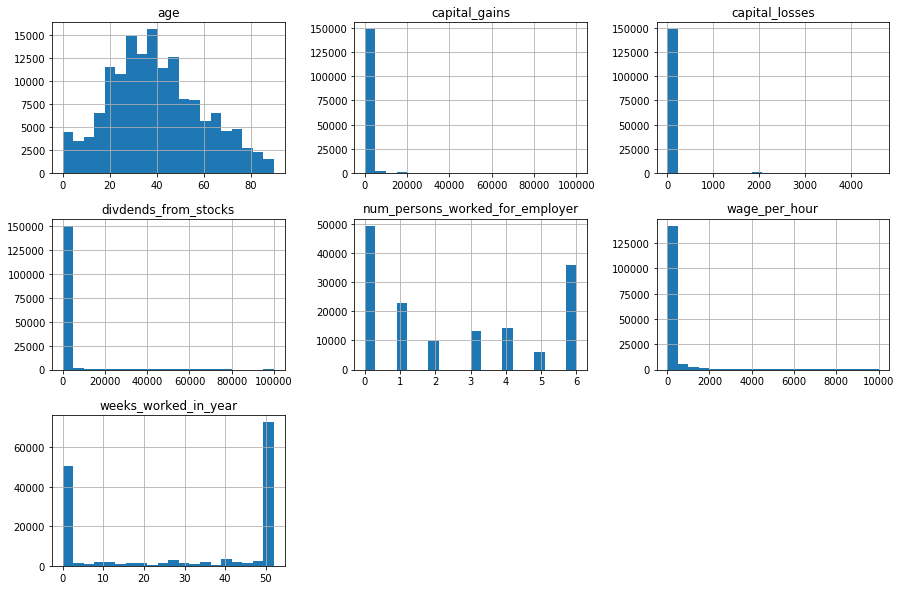

In [15]:
continuous_vars = ['AAGE', 'AHRSPAY', 'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'NOEMP', 'WKSWORK']

df = train[continuous_vars].rename(columns={c: features[c] for c in continuous_vars})
df.hist(figsize=(15,10), bins=20)
plt.show()

> The only "real" continuous variable is the age, the others seem more to be categorical.

> For instance, the capital gains/losses, dividends and hourly wage could be cast as a boolean modelling whether the value of this feature is equal to zero or not.

> About the weeks worked in year, the value could be sorted into three categories : zero (min value), max value (which should be 52) and "other" (all values strictly between min and max)

> Finally some of the "num_persons_worked_for_employer" could be merged, with resulting categories that could be "0", "1-2"; "3-6" (this split has to be tested).

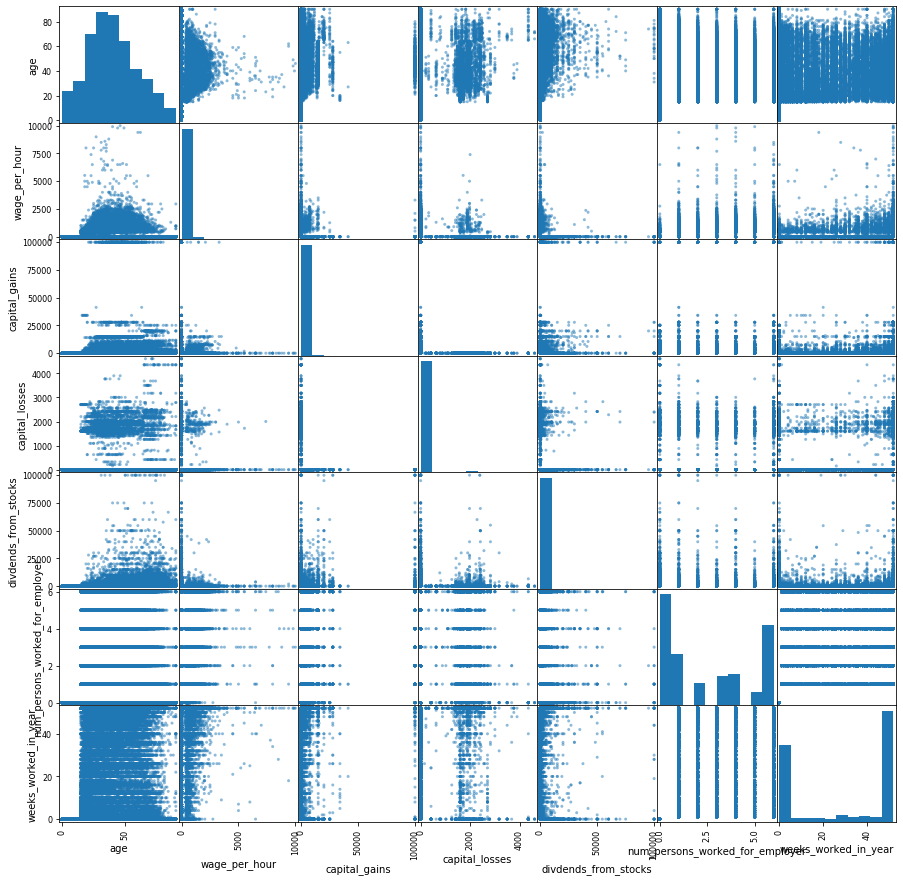

In [40]:
pd.plotting.scatter_matrix(df, figsize=(15, 15))
plt.show()

A fair amount of observations can be made from this plot :
* Children don't work (obviously)
* Middle-aged people tend to have higher wages on average
* Dividends increase as age progesses
* Different behaviours appear when it comes to capital gains/losses

#### Variables related to origins

These features are :
* PEFNTVTY : country of birth of the father
* PEMNTVTY : country of birth of the mother
* PENATVTY : country of birth of the person

In [20]:
import json

# Loading the JSON of the GeoJSON features by country
with open('data/countries.geojson', 'r') as f:
    geojson_base = json.load(f)
    
# This function takes the name of a country and the GeoJSON previously defined
# and returns the Feature associated to this country. Returns nothing if not found.
def geojson_country(name, g=geojson_base):
    for c in g['features']:
        if c['properties']['ADMIN']==name:
            return c

In [21]:
def class_percentage_by_feature(feature, df, classf='YTARGET'):
    dfl = df.groupby([feature]).size().reset_index(name='COUNT')
    dfr = df.groupby([feature, classf]).size().reset_index(name='CLASS_COUNT')
    perc = dfl.merge(dfr, on=feature, how='left')
    
    perc['PERC'] = 100*perc['CLASS_COUNT']/perc['COUNT']
    return perc.reset_index(drop=True)

In [22]:
import difflib
from ipyleaflet import Map, basemaps, basemap_to_tiles, GeoJSON, Polyline, CircleMarker
from geojson import LineString, Point, Feature
from ipywidgets import Layout
from matplotlib import cm
from matplotlib.colors import rgb2hex as to_hex
from math import floor

def percentage_above50k_per_origin(origin_feature, df=train):
    # Inaccurate but necessary : no GeoJSON of England or Scotland alone
    df = df.replace(['England', 'Scotland'], 'United Kingdom')
    
    # Getting the rate of people in the class "+50k" for each country of origin
    perc = class_percentage_by_feature(origin_feature, train)
    perc = perc.loc[perc.YTARGET==1]
    
    # Dropping '?' and 'Outlying-U S' entries
    perc = perc.replace(['?', 'Outlying-U S (Guam USVI etc)'], np.nan).dropna()
    

    # Rescaling percentages on a 0-100 scale
    min_v, max_v = min(perc.PERC), max(perc.PERC)
    perc.PERC = 100*(perc.PERC-min_v)/(max_v-min_v)
    perc.reset_index(inplace=True, drop=True)

    # Gathering the list of the countries and their associated GeoJSON
    freq_by_country = list(zip(perc[origin_feature], perc['PERC']))
    world_countries = [c['properties']['ADMIN'] for c in geojson_base['features']]

    # Displaying the map with colors based on percentages
    defaultLayout=Layout(width='960px', height='600px')

    m = Map(layers=(basemap_to_tiles(basemaps.OpenStreetMap.Mapnik, "2020-02-01"),),
                layout=defaultLayout,
                center=(35, 0),
                zoom=2)

    cmap = cm.get_cmap('RdYlGn', 100)

    for country, freq in freq_by_country:
        closest_matches = difflib.get_close_matches(country, world_countries)
        if len(closest_matches)>0:
            c = closest_matches[0]
            d = geojson_country(c)

            color = to_hex(cmap(floor(freq))[:3])
            g = GeoJSON(data=d, style={'color': color, 'opacity':1, 'weight':1, 'fillOpacity':0.9})

            m.add_layer(g)
    return m, perc

In [19]:
m, perc = percentage_above50k_per_origin('PEFNTVTY') # country of birth of the father
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [20]:
m, perc = percentage_above50k_per_origin('PEMNTVTY') # country of birth of the mother
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [21]:
m, perc = percentage_above50k_per_origin('PENATVTY') # country of birth of the person
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [22]:
train[train.columns.tolist()[:20]].head()

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,ARACE,AREORGN,ASEX,AUNMEM,AUNTYPE,AWKSTAT,CAPGAIN,CAPLOSS,DIVVAL,FILESTAT
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler


### Feature engineering

In [23]:
train.columns

Index(['AAGE', 'ACLSWKR', 'ADTIND', 'ADTOCC', 'AHGA', 'AHRSPAY', 'AHSCOL',
       'AMARITL', 'AMJIND', 'AMJOCC', 'ARACE', 'AREORGN', 'ASEX', 'AUNMEM',
       'AUNTYPE', 'AWKSTAT', 'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'FILESTAT',
       'GRINREG', 'GRINST', 'HHDFMX', 'HHDREL', 'MIGMTR1', 'MIGMTR3',
       'MIGMTR4', 'MIGSAME', 'MIGSUN', 'NOEMP', 'PARENT', 'PEFNTVTY',
       'PEMNTVTY', 'PENATVTY', 'PRCITSHP', 'SEOTR', 'VETQVA', 'VETYN',
       'WKSWORK', 'YEAR', 'YTARGET'],
      dtype='object')

In [157]:
# The recategorizations and the feature selection that follow are mainly inspired by this chunk of code.
# It allow to focus on a (categorical) feature and quickly assess if its classes are discriminant enough and/or
# if some of them can be merged into a new one.

# As I anticipate the use of dummy encoded variables, I need to take care that my categorical features do not have
# too much classes (after dummy encoding : #classes(features) = #new features -1)

f = list(features)[36]
c = class_percentage_by_feature(f, train)
print(features[f])
c.loc[c.YTARGET].sort_values('PERC', ascending=False)

own_business_or_self_employed


,SEOTR,COUNT,YTARGET,CLASS_COUNT,PERC
3,1,2684,True,606,22.578241
5,2,16058,True,1318,8.207747
1,0,133306,True,10386,7.791097


In [114]:
def cat_AAGE(x):
    if x<21: return "0-20"
    elif x<31: return "21-30"
    elif x<41: return "31-40"
    elif x<61: return "41-60"
    else: return "61+"

In [115]:
def cat_AHGA(x):
    if x in ['10th grade', 'Children', 'Less than 1st grade', '7th and 8th grade', '12th grade no diploma', '5th or 6th grade', '11th grade', '9th grade', '1st 2nd 3rd or 4th grade']:
        return 'No degree'
    elif x in ['High school graduate', 'Some college but no degree']:
        return 'High School'
    elif x in ['Bachelors degree(BA AB BS)', 'Associates degree-academic program', 'Associates degree-occup /vocational']:
        return 'Undergraduate'
    elif x in ['Masters degree(MA MS MEng MEd MSW MBA)',]:
        return 'Graduate'
    elif x in ['Prof school degree (MD DDS DVM LLB JD)', 'Doctorate degree(PhD EdD)']:
        return 'PhD'
    else:
        return 'No degree'

In [116]:
def cat_ACLSWKR(x):
    if x in ["Self-employed-not incorporated", "State government", "Local government", "Private"]:
        return "MixedCategory10"
    if x in ["Not in universe", "Without pay", "Never worked"]:
        return "MixedCategory1"
    else:
        return x

In [117]:
def cat_HHDFMX(x):
    if x in ["Householder", "Spouse of householder"]:
        return x
    elif x in ["Spouse of RP of unrelated subfamily", "Nonfamily householder"]:
        return "MixedCategory9"
    else:
        return "MixedCategory3"

In [118]:
def cat_HHDREL(x):
    if x in ["Householder", "Spouse of householder"]:
        return x
    elif x in ["Nonrelative of householder", "Other relative of householder"]:
        return "OtherRelative"
    else:
        return "Child"

In [119]:
train.columns

Index(['AAGE', 'ACLSWKR', 'ADTIND', 'ADTOCC', 'AHGA', 'AHRSPAY', 'AHSCOL',
       'AMARITL', 'AMJIND', 'AMJOCC', 'ARACE', 'AREORGN', 'ASEX', 'AUNMEM',
       'AUNTYPE', 'AWKSTAT', 'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'FILESTAT',
       'GRINREG', 'GRINST', 'HHDFMX', 'HHDREL', 'MIGMTR1', 'MIGMTR3',
       'MIGMTR4', 'MIGSAME', 'MIGSUN', 'NOEMP', 'PARENT', 'PEFNTVTY',
       'PEMNTVTY', 'PENATVTY', 'PRCITSHP', 'SEOTR', 'VETQVA', 'VETYN',
       'WKSWORK', 'YEAR', 'YTARGET'],
      dtype='object')

In [182]:
selected_features = ["AAGE", "ACLSWKR", "AHGA", "AHRSPAY", "ASEX", "CAPGAIN", "CAPLOSS", "DIVVAL", "HHDFMX", "HHDREL",
"NOEMP", "WKSWORK", "SEOTR", "YEAR", "YTARGET"]

def selection_and_treatment(df, l=selected_features):  
    sel = df.copy()[l]
    for f in ["AAGE", "AHGA", "ACLSWKR", "HHDFMX", "HHDREL"]:
        sel[f] = sel[f].map(lambda x: eval("cat_"+f)(x))
    sel["SEOTR"] = sel.SEOTR.astype(str)
    return sel

dum_train = pd.get_dummies(selection_and_treatment(train))
dum_test = pd.get_dummies(selection_and_treatment(test))

In [183]:
print(dum_train.shape)
print(dum_test.shape)

(152048, 35)
(78473, 35)


### Prediction

##### AdaBoost

In [187]:
X_train = dum_train.drop('YTARGET', axis=1).to_numpy().astype(float)
y_train = dum_train['YTARGET'].to_numpy().astype(float)

X_test = dum_test.drop('YTARGET', axis=1).to_numpy().astype(float)
y_test = dum_test['YTARGET'].to_numpy().astype(float)

In [188]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

model = AdaBoostClassifier(learning_rate=.1)
model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=50, random_state=None)

In [189]:
model.score(X_test.astype(float), y_test.astype(float))

0.9257706472289832

In [190]:
# feature importance
for k, l in zip(dum_train.columns.tolist(), model.feature_importances_):
    print(k,":",l)

AHRSPAY : 0.0
CAPGAIN : 0.1
CAPLOSS : 0.02
DIVVAL : 0.12
NOEMP : 0.0
WKSWORK : 0.16
YEAR : 0.0
YTARGET : 0.02
AAGE_0-20 : 0.04
AAGE_21-30 : 0.0
AAGE_31-40 : 0.02
AAGE_41-60 : 0.0
AAGE_61+ : 0.0
ACLSWKR_Federal government : 0.0
ACLSWKR_MixedCategory1 : 0.0
ACLSWKR_MixedCategory10 : 0.0
ACLSWKR_Self-employed-incorporated : 0.0
AHGA_Graduate : 0.1
AHGA_High School : 0.14
AHGA_No degree : 0.04
AHGA_PhD : 0.0
AHGA_Undergraduate : 0.12
ASEX_Female : 0.02
ASEX_Male : 0.0
HHDFMX_Householder : 0.06
HHDFMX_MixedCategory3 : 0.0
HHDFMX_MixedCategory9 : 0.0
HHDFMX_Spouse of householder : 0.02
HHDREL_Child : 0.02
HHDREL_Householder : 0.0
HHDREL_OtherRelative : 0.0
HHDREL_Spouse of householder : 0.0
SEOTR_0 : 0.0
SEOTR_1 : 0.0


##### XGBoost

In [166]:
from xgboost import XGBClassifier

max_depth= [2,4,6,8] 
min_child_weight = [2,3,4]
reg_alpha=  [0,0.1,1,2]
reg_lambda = [0,0.1,1,2]

param_grid = [
  {'max_depth': max_depth,
   'min_child_weight': min_child_weight,
   'reg_alpha': reg_alpha,
   'reg_lambda': reg_lambda}
 ]

model = GridSearchCV(XGBClassifier(), param_grid, cv=5, n_jobs=-1)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

xgb_params = model.best_params_
param_grid_lr = {'learning_rate': [0.001, 0.01,0.05,0.02,0.1,]}

model = GridSearchCV(XGBClassifier(**xgb_params), param_grid_lr, cv=5, n_jobs=-1)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

xgb_params.update(model.best_params_)
print(xgb_params)

0.9999745135269456
0.9999745135269456
{'max_depth': 4, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 0.1, 'learning_rate': 0.1}


In [191]:
params = {'max_depth': 4, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 0.1, 'learning_rate': 0.1}
xgb_model = XGBClassifier(**params)
xgb_model.fit(X_train, y_train)
xgb_model.feature_importances_

array([0.01131895, 0.04253601, 0.01702687, 0.03425044, 0.01602704,
       0.08628074, 0.00182492, 0.01070305, 0.06328636, 0.00094525,
       0.02810909, 0.00292715, 0.00398801, 0.00443227, 0.00331526,
       0.02552193, 0.07630256, 0.08295002, 0.08436326, 0.06373853,
       0.07883257, 0.055294  , 0.        , 0.01051622, 0.12615432,
       0.00878781, 0.00483896, 0.02907618, 0.01015171, 0.00138485,
       0.00485455, 0.00245918, 0.00535488, 0.00244708], dtype=float32)

In [192]:
xgb_model.score(X_test, y_test)

0.9408713825137308